Import all necessary libraries. These can be installed with `poetry install --no-root`

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### **Data Loading**

The data loading starts by defining the transforms. The transforms.Compose() defines a sequence of transforms to perform on the dataset.
- transforms.ToTensor(): Converts the data to tensors
- transforms.Normalize(): Normalizes the data - since this data is pixel values, there are three channels that need normalized (RGB). They're being normalized to between 0 and 1, so the mean and std are both 0.5 for each channel

The data is then downloaded from the torchvision datasets and wrapped as DataLoaders so that they can be iterated over for training/evaluation

In [2]:
# Define the batch size and number of workers
BATCH_SIZE = 4
NUM_WORKERS = 4

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
target_transform = transforms.Compose([lambda x: F.one_hot(x, num_classes=10).to(float)])

# Download and load the training data
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### **Convolutional Neural Network (CNN)**

Since the images are bigger than the MNIST dataset (32x32 vs 28x28) and they have more features to represent (animals with background noise vs black and white numbers), the CIFAR dataset requires a convolutional neural network. This process is shown in the GIF below.

![convolution_gif](images/convolution.gif)  
*From ![https://github.com/nvan21/image-classification]*

This network has two convolutional layers, then a max pooling layer, finished off by three fully connected linear layers. Each layer is explained below.
- **Convolution Layer 1:** This layer takes in 3 inputs (since there is a red, green, and blue channel) and has an output of 6 channels (arbitrary number of kernel features that the network will learn). Each kernel is a matrix of weights that are trained to detect image features like edges, textures, etc. For this network, the output image size will be 28x28 since there's a 5x5 kernel with no padding. This means that a 2 pixel wide ring will be lost (4 pixels in each dimension).
- **Convolution Layer 2:** This layer takes in 6 inputs (the outputs from the previous layer) and has 16 outputs. This means the network will learn 16 different features through the 16 different kernel matrices. The input image size to this layer is 14x14 since there's a 2x2 max pooling layer between this layer and the first convolutional layer (read below). The output image size will be 10x10 for the same reason as convolution layer 1.
- **2D Max Pooling:** This layer takes the two image dimensions and does a max sliding operation to reduce dimensionality. It does this by taking the max value in a kernel (2x2 is standard and is what's used in this network), and then mapping that value to a new image matrix. The image size is 28x28 for the first pooling operation, so the output would be 14x14. The image size is 10x10 for the second pooling operation, so the output would be 5x5. The GIF below shows this operation in action.

![pooling_gif](images/max_pooling.gif)  
*From https://www.quora.com/What-is-pooling-in-a-deep-architecture*

- **Linear Layer 1:** This layer is the start of the fully connected portion of the network. The important thing to note here is the input dimension. The equation is $N_{in} = f * w * h$ where $N_{in}$ is the number of input nodes for the linear layer, $f$ is the number of output features from the last convolution layer, and $w$ and $h$ are the width and height of the image data respectively after it's gone through the convolution layers. In this setup, the number of input layer nodes would be $N_{in} = 16 * 5 * 5 = 800$. The 120 node output of this layer is an arbitrary number that's meant to slowly reduce the dimensionality to the 10 class classification.
- **Linear Layer 2:** This layer is an arbitrary layer that reduces the number of dimensions from 120 to 84.
- **Linear Layer 3:** This is the last linear layer, so the number of output nodes has to be equal to the number of classes. Since the CIFAR-10 dataset has 10 classes, this layer has 10 outputs.

### **Forward Pass**
The network takes the batch image data and feeds it through the different layers. It starts by feeding the data through the first convolution layer, and then applying the ReLU activation function (shown below). This induces non-linearity into the model which is important for the network to learn complex features. The output of this convolution layer then undergoes a pooling operation to reduce the dimensionality. This process is repeated one more time with the next convolution layer. Before the output of the last convolution layer is fed into the fully connected portion of the network, the tensor is flattened to two dimensions instead of four. The data is then fed through the three linear layers with a ReLU activation function for the first two, and no activation function for the last layer. It returns the raw probability logits.

![relu](images/relu.ppm)  
*Image from https://www.researchgate.net/figure/Relu-activation-function-graph_fig3_336585385*

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

### **Learning Functions**

This program uses cross entropy loss for the loss function and Adam as the network optimizer. The equation for multi-class classification is $L = -\Sigma_{i=1}^{C}y_i\log{\hat{y_i}}$, where $L$ is the loss, $C$ is the number of classes, $y_i$ is a one-hot encoded vector of the classes, and $\hat{y_i}$ is the predicted probability vector from the network.

In [4]:
cnet = ConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(cnet.parameters(), lr=0.001)

cuda


### **Data Structure**

When iterating through the DataLoader, each data point has the following shape:


`data.shape = [batch_size, image_channels, pixel_width, pixel_height]`

- **batch_size**: The number of images per batch
- **image_channels**: The number of channels per image (i.e. 3 for RGB images)
- **pixel_width**: The width of an individual image in pixels
- **pixel_height**: The height of an individual image in pixels

The data is then transformed so that the image channels, pixel width, and pixel height are flattened to one dimension. This makes the following data shape:

`data.shape = [batch_size, image_channels * pixel_width * pixel_height]`


In [9]:
# Store the epoch and loss data for plotting purposes later on
epochs = []
losses = []

# Number of training epochs
n_epochs = 100

for epoch in range(n_epochs):
    print(f"Starting training for epoch {epoch}")
    N = len(train_loader)

    for idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        logits = cnet(data)
        loss = loss_fn(logits, target)

        optim.zero_grad()
        loss.backward()
        optim.step()

        epochs.append(epoch + idx/N)
        losses.append(loss.item())

epochs = np.array(epochs)
losses = np.array(losses)

Starting training for epoch 0
Starting training for epoch 1
Starting training for epoch 2
Starting training for epoch 3
Starting training for epoch 4
Starting training for epoch 5
Starting training for epoch 6
Starting training for epoch 7
Starting training for epoch 8
Starting training for epoch 9
Starting training for epoch 10
Starting training for epoch 11
Starting training for epoch 12
Starting training for epoch 13
Starting training for epoch 14
Starting training for epoch 15
Starting training for epoch 16
Starting training for epoch 17
Starting training for epoch 18
Starting training for epoch 19
Starting training for epoch 20
Starting training for epoch 21
Starting training for epoch 22
Starting training for epoch 23
Starting training for epoch 24
Starting training for epoch 25
Starting training for epoch 26
Starting training for epoch 27
Starting training for epoch 28
Starting training for epoch 29
Starting training for epoch 30
Starting training for epoch 31
Starting training 

Text(0.5, 1.0, 'Losses per Epoch')

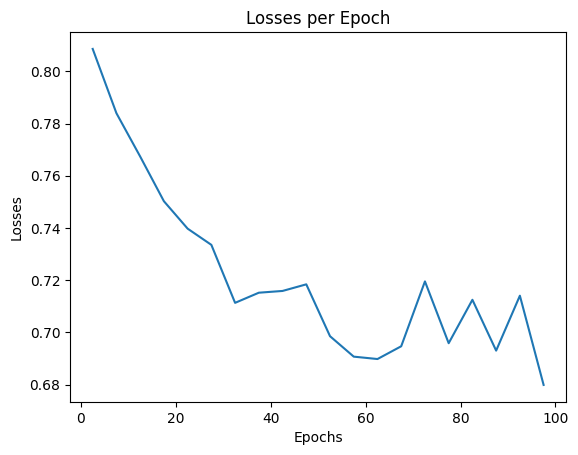

In [10]:
epochs_avg = epochs.reshape(20, -1).mean(axis=1)
losses_avg = losses.reshape(20, -1).mean(axis=1)
plt.plot(epochs_avg, losses_avg)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Losses per Epoch")

In [13]:
torch.save(cnet.state_dict(), "model.pt")